In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [2]:
import cv2  # OpenCV for image processing

In [3]:
train_dir = r"C:\Users\skgau\OneDrive\Desktop\major_project\skin-disease-datasaet\train_set"
test_dir = r"C:\Users\skgau\OneDrive\Desktop\major_project\skin-disease-datasaet\test_set"
img_size = 224
batch_size = 32
num_classes = 8

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 741 images belonging to 8 classes.
Found 183 images belonging to 8 classes.
Found 233 images belonging to 8 classes.


In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base model

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Preprocess an image using OpenCV
def preprocess_image_with_opencv(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Predict using image file path
def predict_skin_disease(image_path):
    image = preprocess_image_with_opencv(image_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_indices = train_gen.class_indices
    labels = dict((v, k) for k, v in class_indices.items())
    return labels[predicted_class], prediction

In [8]:
# Webcam-based prediction (Optional)
def predict_from_webcam():
    cap = cv2.VideoCapture(0)
    print("Press 'q' to capture and predict.")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow("Webcam - Press 'q' to capture", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            image = cv2.resize(frame, (224, 224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype("float32") / 255.0
            image = np.expand_dims(image, axis=0)
            prediction = model.predict(image)
            predicted_class = np.argmax(prediction, axis=1)[0]
            class_indices = train_gen.class_indices
            labels = dict((v, k) for k, v in class_indices.items())
            print(f"Predicted Skin Condition: {labels[predicted_class]}")
            break
    cap.release()
    cv2.destroyAllWindows()

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)

In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

c:\Users\skgau\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2772 - loss: 2.1260

c:\Users\skgau\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.2831 - loss: 2.1078 - val_accuracy: 0.7377 - val_loss: 0.8339 - learning_rate: 0.0010
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6788 - loss: 0.9322 - val_accuracy: 0.8197 - val_loss: 0.6299 - learning_rate: 0.0010
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8066 - loss: 0.6158 - val_accuracy: 0.8525 - val_loss: 0.4527 - learning_rate: 0.0010
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8620 - loss: 0.3994 - val_accuracy: 0.8634 - val_loss: 0.4413 - learning_rate: 0.0010
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8608 - loss: 0.4319 - val_accuracy: 0.8634 - val_loss: 0.4039 - learning_rate: 0.0010
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8439 - loss: 0.4533 - val_accuracy: 0.8852 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8947 - loss: 0.3041 - val_accuracy: 0.8798 - va

In [11]:
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 843ms/step - accuracy: 0.9342 - loss: 0.1830
Test Accuracy: 0.9056, Test Loss: 0.2601


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step 


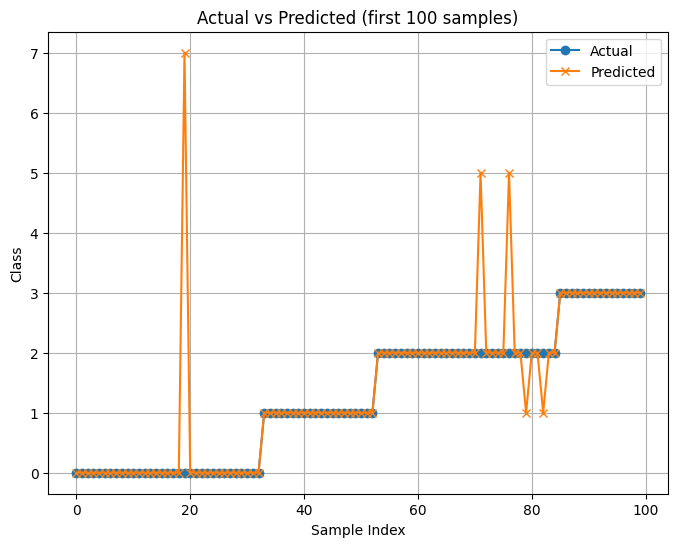

In [12]:
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

plt.figure(figsize=(8, 6))
plt.plot(y_true[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted (first 100 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class")
plt.grid(True)
plt.show()

In [13]:
model.save("skin_disease_model.h5")


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

In [15]:
model = load_model('skin_disease_model.h5')

In [16]:
class_names = ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
               'Atopic Dermatitis Photos', 'Cellulitis Impetigo and other Bacterial Infections',
               'Eczema Photos', 'Herpes HPV and other STDs Photos',
               'Psoriasis Lichen Planus and related diseases', 'Tinea Ringworm Candidiasis and other Fungal Infections']

In [17]:
def predict_skin_disease(img_path=r"C:\Users\skgau\OneDrive\Desktop\major_project\download.jpeg"):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_batch)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.2f}")

    plt.imshow(img)
    plt.title(f"Prediction: {class_names[predicted_class]} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
Confidence: 0.98


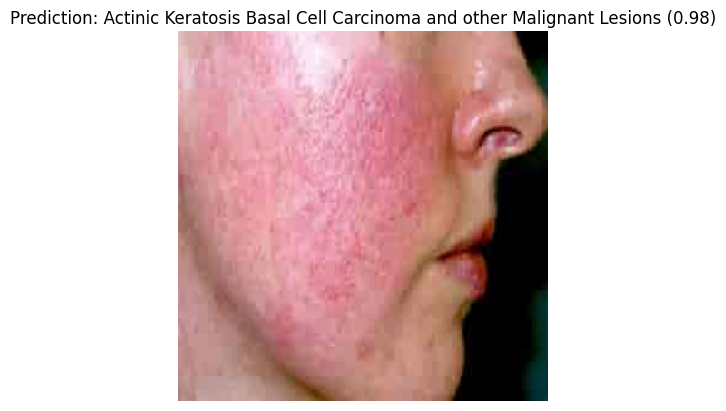

In [18]:
predict_skin_disease(r"C:\Users\skgau\OneDrive\Desktop\major_project\download.jpeg")  # Replace with your image path

In [19]:
# Save the trained model to H5 format
model.save("skin_disease_model_updated.h5")
